<h1> ______________________________________ </h1>

<h1> Full NEXT100 with fiber panels simulation mapping analysis </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we take as input the maps created in the previous notebook and use it to simulate an s2 signal for bb0nu events. </p>




<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> 100K ie S2 events. </p>
-  <p style="font-size: 17px; color: black;"> Mapping separated by sensors. </p>

-  <p style="font-size: 17px; color: black;"> Geant4 fundamental units: </p>

 -  <p style="font-size: 17px; color: black;"> Length [L]: mm (milimeter) </p>
 -  <p style="font-size: 17px; color: black;"> Time [T]: ns (nanosecond) </p>
 -  <p style="font-size: 17px; color: black;"> Energy [E]: MeV (megaelectronvolt) </p>





In [1]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy                import stats, integrate
from scipy.signal         import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker    import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches   import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables             as tb

# Functions

In [2]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    return a*stats.norm.pdf(x, mu, sigma) 

def gauss_sum(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)


In [3]:
def s2_waveform(event, sensor):
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7), constrained_layout=True)
    
    font_size = 15
    ev = f'{event}'
    sens = f'sens_{sensor}'

    # Open the HDF5 file in read mode
    with h5py.File(filename, 'r') as file:

        # Get the group corresponding to the current key
        group = file[ev]


        # Get and print the value corresponding to the current subkey
        signal = group[sens][()]
        signal = pd.DataFrame(signal)
        signal.rename(columns = columns, inplace=True)



        t = signal.time*1e-3 # [us]
        s2 = signal.s2 # [e]
        
        bin_width = 1 # time units ([us])
        
        binin = np.arange(t.min() - bin_width, t.max() + 2*bin_width, bin_width)

        events, bins, bars = ax.hist(t, binin, 
                                     weights = s2,
                                     density=False,
                                     histtype='step',
                                     label = f's2 of event {ev} in {sens} using maps'
                                    )
        ax.set_title(f's2 of event {ev} in {sens}', fontsize = font_size);
        ax.set_xlabel('Time [us]', fontsize = font_size);
        ax.set_ylabel('Signal [e]', fontsize = font_size);

        ax.tick_params(axis='both', labelsize = font_size*2/3)
    
            

# Reading the file

In [4]:
path = '/home/investigator/mariandbt/python/data'
path = path + '/20231025_NEXT100_full_mapping'

# filename = os.path.join(path, "bb0nu_s2_signal.h5")
# filename = os.path.join(path, "20231215_bb0nu_s2_signal.h5")
# filename = os.path.join(path, "20231218_bb0nu_s2_signal.h5")
# filename = os.path.join(path, "20231220_bb0nu_100ev_s2_signal.h5")
# filename = os.path.join(path, "20231226_bb0nu_100ev_s2_signal.h5")
# filename = os.path.join(path, "20240109_bb0nu_100ev_s2_signal.h5")
# filename = os.path.join(path, "20240113_bb0nu_200ev_s2_signal.h5")
filename = os.path.join(path, "20240122_bb0nu_1fullev_s2_signal.h5")


In [5]:
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/python/data/20231025_NEXT100_full_mapping/20240122_bb0nu_1fullev_s2_signal.h5 (File) ''
Last modif.: '2024-01-24T14:56:21+00:00'
Object Tree: 
/ (RootGroup) ''
/0 (Group) ''
/0/sens_200 (Array(101342, 2)) ''
/0/sens_201 (Array(101342, 2)) ''
/0/sens_202 (Array(101342, 2)) ''
/0/sens_203 (Array(101342, 2)) ''
/0/sens_204 (Array(101342, 2)) ''
/0/sens_205 (Array(101342, 2)) ''
/0/sens_206 (Array(101342, 2)) ''
/0/sens_207 (Array(101342, 2)) ''
/0/sens_208 (Array(101342, 2)) ''
/0/sens_209 (Array(101342, 2)) ''
/0/sens_210 (Array(101342, 2)) ''
/0/sens_211 (Array(101342, 2)) ''
/0/sens_212 (Array(101342, 2)) ''
/0/sens_213 (Array(101342, 2)) ''
/0/sens_214 (Array(101342, 2)) ''
/0/sens_215 (Array(101342, 2)) ''
/0/sens_216 (Array(101342, 2)) ''
/0/sens_217 (Array(101342, 2)) ''
/0/sens_218 (Array(101342, 2)) ''
/0/sens_219 (Array(101342, 2)) ''
/0/sens_220 (Array(101342, 2)) ''
/0/sens_221 (Array(101342, 2)) ''
/0/sens_222 (Array(101342, 2)) ''
/0/sens_223 (Ar

In [6]:
# We read each file, make the histogram and save JUST the max value of that histogram in s2_max_dict

import h5py

# Load the 3D dictionary from the HDF5 file

columns = {0:'time',
           1:'s2'
          }

bin_width = 1000 # [ns] = 1 [us]
s2_max_dict = {} # s2 peak per sensor
full_s2_max_dict = {} # s2 peak per event

# Open the HDF5 file in read mode
with h5py.File(filename, 'r') as file:
    # Iterate through the top-level keys (groups) in the HDF5 file
    for key in file.keys():
        # Get the group corresponding to the current key
        group = file[key]
        full_s2 = []
        
        # Print the top-level key
        print(f'Top-level key: {key}')
        
        # Iterate through the subkeys (datasets) in the current group
        for subkey in group.keys():
            
            # Check if subkey is already in the dictionary
            if subkey not in s2_max_dict:
                s2_max_dict[subkey] = []
            
            # Get and print the value corresponding to the current subkey
            signal = group[subkey][()]
            signal = pd.DataFrame(signal)
            signal.rename(columns = columns, inplace=True)
            
            t = signal.time
            s2 = signal.s2
            binin = np.arange(t.min() - bin_width, t.max() + 2*bin_width, bin_width)
            
            # Create a histogram
            hist_values, bin_edges = np.histogram(t, bins=binin,
                                                  weights = s2)
            
#             print(f'Subkey: {subkey}, Value: {value}')

            full_s2.append(hist_values.max()) # peak of s2 signal
            s2_max_dict[subkey].append(hist_values.max()) # peak of s2 signal
    
        full_s2_max_dict[key] = max(full_s2)
            


Top-level key: 0


In [7]:
len(s2_max_dict.values())
full_s2_max_dict

{'0': 1387.5663774507993}

In [8]:
s2_max_dict.keys()
full_s2_max_dict.keys()


dict_keys(['0'])

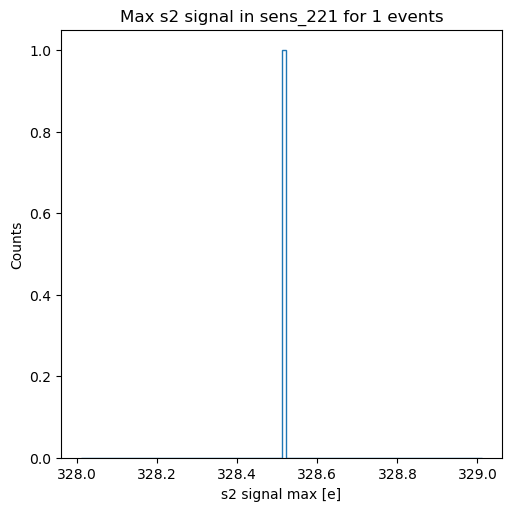

In [9]:
sensor = 'sens_221'

s2 = s2_max_dict[sensor]
s2 = np.array(s2)
n_events = np.size(s2)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), constrained_layout=True)

bin_width = 1 # [e]
n_bins = 100
# binin = np.arange(s2.min() - bin_width, s2.max() + 2*bin_width, bin_width)
binin = n_bins

font_size = 8.5

events, bins, bars = ax.hist(s2, binin, 
                             density=False,
                             label='s2', 
                             histtype='step')

ax.set_title(f'Max s2 signal in {sensor} for {n_events} events');
ax.set_xlabel('s2 signal max [e]');
ax.set_ylabel('Counts');


In [10]:
subkey

'sens_289'

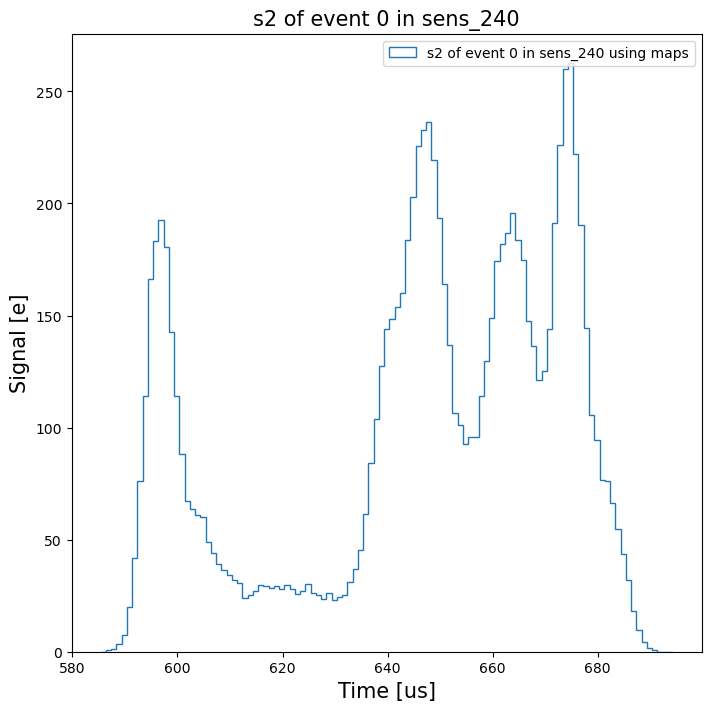

In [11]:
s2_waveform(0, 240)
plt.legend()

<h1> __________________________ </h1>
<h2> Global parameters </h2>

In [12]:
dark25 = 2000 # [Kcps] (1Kcps = 1e3 dark pulses per second) DCR at 25ºC
x_talk = 7 # [%] Probability of a dark count to be 2pe instead of 1pe

n_sensors = 90 

t_binning = 0.1 # [ns] Conversion constant from bin enumerations to nanoseconds (binning used in the simulation)
dT = 5.3 # [ºC] Decay factor at which the dark rate halves

<h1> __________________________ </h1>
<h2> Files </h2>

In [13]:
path = '/home/investigator/mariandbt/python/data/'
path = path + '/20231025_NEXT100_full_mapping/next100_fibers'

new_filename = os.path.join(path, "20240122_Next100_bb_1.next.h5") # 1 full bb w s2

In [14]:
with tb.open_file(new_filename) as file:
    print(file)

/home/investigator/mariandbt/python/data//20231025_NEXT100_full_mapping/next100_fibers/20240122_Next100_bb_1.next.h5 (File) ''
Last modif.: '2024-01-24T09:19:06+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(47,)) ''
/MC/hits (Table(786,)) ''
/MC/particles (Table(101386,)) ''
/MC/sns_positions (Table(3431,)) ''
/MC/sns_response (Table(2615102,)) ''



In [15]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
data = pd.read_hdf(new_filename, "/MC/sns_response")
particles = pd.read_hdf(new_filename, "/MC/particles")


In [16]:
dst = data.copy()
dst_particle = particles.copy()


In [17]:
sens_mask = pd.read_hdf(new_filename, "/MC/sns_positions", where='sensor_name == F_SENSOR')['sensor_id']


/home/investigator/miniconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/pandas/io/pytables.py:3523: IncompatibilityWarning: 
where criteria is being ignored as this version [0.0.0] is too old (or
not-defined), read the file in and write it out to a new file to upgrade (with
the copy_to method)

  warnings.warn(ws, IncompatibilityWarning)


In [18]:
sens_mask[0]

251

In [19]:
dst_fibers = dst.loc[dst.sensor_id.isin(sens_mask)] # dst only for the sensor on the fibers
dst_fibers.time_bin = dst_fibers.time_bin*t_binning # change units to ns


/home/investigator/miniconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [20]:
sens = sens_mask[23]
# sens = 204
dst_onesens = dst_fibers.loc[dst_fibers.sensor_id == sens]

In [21]:
dst_onesens

,event_id,sensor_id,time_bin,charge
782783,0,240,34.7,1
782784,0,240,70.8,1
782785,0,240,74.5,1
782786,0,240,74.8,1
782787,0,240,87.3,1
...,...,...,...,...
801349,0,240,687722.0,1
801350,0,240,688551.6,1
801351,0,240,688565.3,1
801352,0,240,688868.9,1


<h1> __________________________ </h1>
<h2> Analysis </h2>

-  <p style="font-size: 17px; color: black;"> <b> Direct s2 waveform </b> </p>

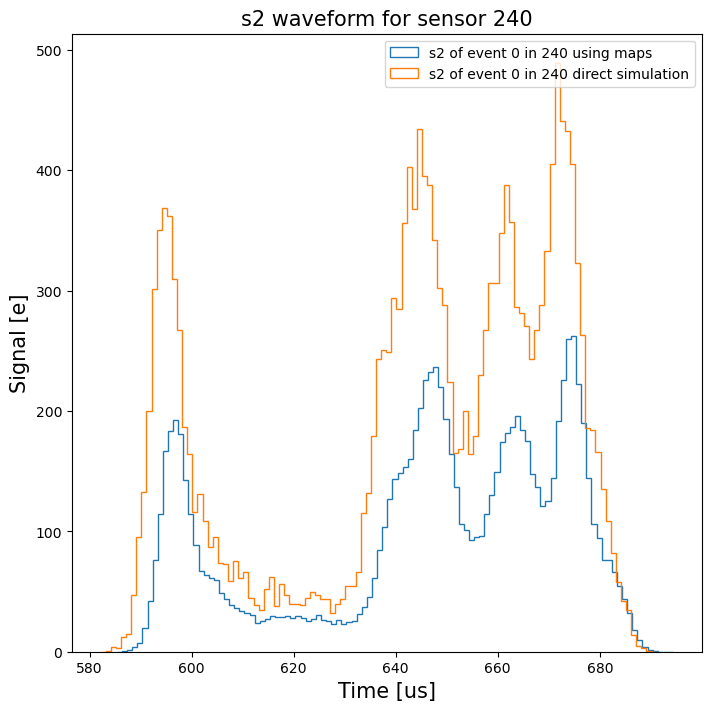

In [31]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7), constrained_layout=True)
# s2_waveform(0, 240)

font_size = 15
ev = '0'
sensor = f'sens_{sens}'

# Open the HDF5 file in read mode
with h5py.File(filename, 'r') as file:

    # Get the group corresponding to the current key
    group = file[ev]


    # Get and print the value corresponding to the current subkey
    signal = group[sensor][()]
    signal = pd.DataFrame(signal)
    signal.rename(columns = columns, inplace=True)



    t = signal.time*1e-3 # [us]
    s2 = signal.s2 # [e]

    bin_width = 1 # time units ([us])

    binin = np.arange(t.min() - bin_width, t.max() + 2*bin_width, bin_width)

    events, bins, bars = ax.hist(t, binin, 
                                 weights = s2,
                                 density=False,
                                 histtype='step',
                                 label = f's2 of event {ev} in {sens} using maps'
                                )
#     ax.set_title(f's2 of event {ev} in {sens}', fontsize = font_size);
#     ax.set_xlabel('Time [us]', fontsize = font_size);
#     ax.set_ylabel('Signal [e]', fontsize = font_size);

#     ax.tick_params(axis='both', labelsize = font_size*2/3)

# font_size = 15

# signal = dst_fibers
signal = dst_onesens

tt = signal.time_bin*1e-3 # [us]
s2 = signal.charge # [e]

t_window_min = 400 # [us]
t_window_max = 1000 # [us]

t_window = (t_window_min < tt) & (tt < t_window_max)

t = tt[t_window]
s2 = s2[t_window]


bin_width = 1 # time units ([us])

binin = np.arange(t.min() - bin_width, t.max() + 2*bin_width, bin_width)

events, bins, bars = ax.hist(t, binin, 
                             weights = s2,
                             density=False,
                             histtype='step',
                             label = f's2 of event {0} in {sens} direct simulation'
                            )

ax.set_title(f's2 waveform for sensor {sens}', fontsize = font_size);
ax.set_xlabel('Time [us]', fontsize = font_size);
ax.set_ylabel('Signal [e]', fontsize = font_size);

ax.tick_params(axis='both', labelsize = font_size*2/3)

ax.legend()


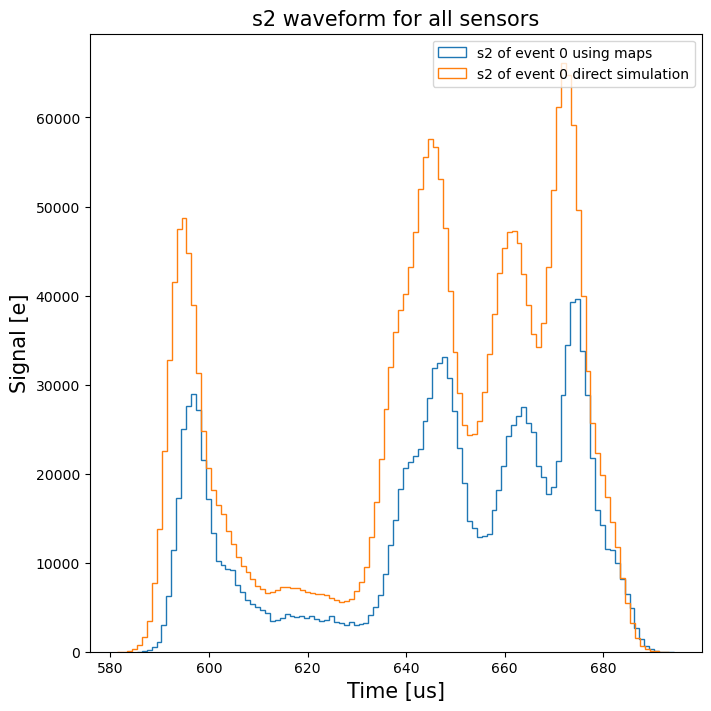

In [54]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7), constrained_layout=True)
# s2_waveform(0, 240)

font_size = 15
ev = '0'
sensor = f'sens_{sens}'

# Open the HDF5 file in read mode
with h5py.File(filename, 'r') as file:

    # Get the group corresponding to the current key
    group = file[ev]
    
    # Get a list of all keys (sensor names) in the group
    sensor_keys = list(group.keys())

    # Use list comprehension to get all datasets (signals) for all sensors in the group
    all_signals = [group[sensor_key][()] for sensor_key in sensor_keys]

    # Convert the list of signals to a DataFrame
    df_all_sensors = pd.DataFrame(np.concatenate(all_signals))

    # Assuming 'columns' is defined elsewhere in your code
    df_all_sensors.rename(columns=columns, inplace=True)


    t = df_all_sensors.time*1e-3 # [us]
    s2 = df_all_sensors.s2 # [e]

    bin_width = 1 # time units ([us])

    binin = np.arange(t.min() - bin_width, t.max() + 2*bin_width, bin_width)

    events, bins, bars = ax.hist(t, binin, 
                                 weights = s2,
                                 density=False,
                                 histtype='step',
                                 label = f's2 of event {ev} using maps'
                                )

signal = dst_fibers

tt = signal.time_bin*1e-3 # [us]
s2 = signal.charge # [e]

t_window_min = 400 # [us]
t_window_max = 1000 # [us]

t_window = (t_window_min < tt) & (tt < t_window_max)

t = tt[t_window]
s2 = s2[t_window]


bin_width = 1 # time units ([us])

binin = np.arange(t.min() - bin_width, t.max() + 2*bin_width, bin_width)

events, bins, bars = ax.hist(t, binin, 
                             weights = s2,
                             density=False,
                             histtype='step',
                             label = f's2 of event {0} direct simulation'
                            )

ax.set_title(f's2 waveform for all sensors', fontsize = font_size);
ax.set_xlabel('Time [us]', fontsize = font_size);
ax.set_ylabel('Signal [e]', fontsize = font_size);

ax.tick_params(axis='both', labelsize = font_size*2/3)

ax.legend()


In [ ]:
len(h5py.File(filename, 'r').keys())

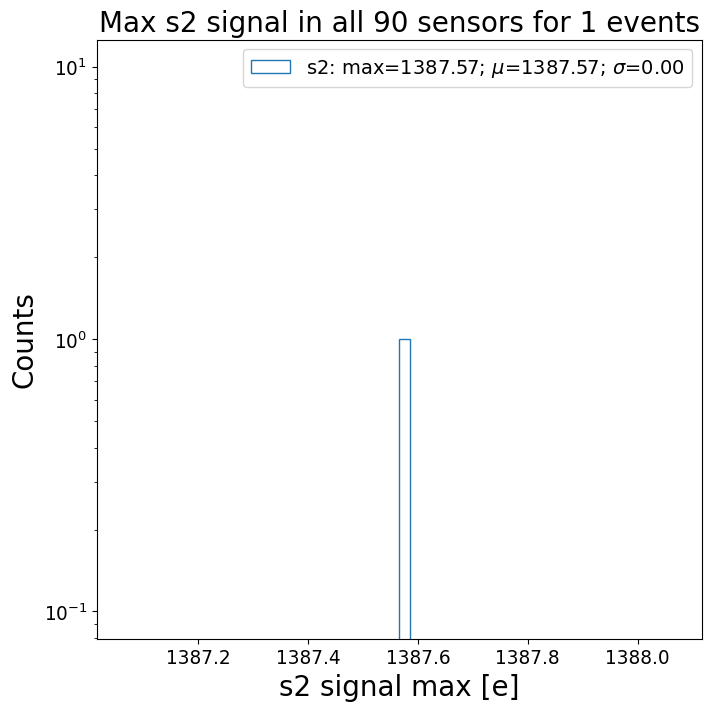

In [32]:
# s2 = np.array(list(s2_max_dict.values()))
s2 = np.array(list(full_s2_max_dict.values()))

n_events = np.shape(s2)[0]
# n_events = np.shape(s2)[1]
n_sensors = 90

# s2 = np.concatenate(s2)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7,7), constrained_layout=True)

bin_width = 1 # [e]
n_bins = 50
# binin = np.arange(s2.min() - bin_width, s2.max() + 2*bin_width, bin_width)
binin = n_bins

font_size = 20

events, bins, bars = ax.hist(s2, binin, 
                             density=False,
                             label='s2: max=%.2f; $\mu$=%.2f; $\sigma$=%.2f'%(s2.max(), s2.mean(), s2.std()), 
                             histtype='step')

ax.set_title(f'Max s2 signal in all {n_sensors} sensors for {n_events} events', fontsize = font_size);
ax.set_xlabel('s2 signal max [e]', fontsize = font_size);
ax.set_ylabel('Counts', fontsize = font_size);
ax.set_yscale('log')

ax.legend(fontsize=0.7*font_size, loc='best')

ax.tick_params(axis='both', labelsize = font_size*2/3)

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15,10), constrained_layout=True)

s2 = np.array(list(s2_max_dict.values()))
s2 = np.concatenate(s2)

# Create a histogram
events, bin_ref = np.histogram(s2, bins=binin)

# Plot the histogram
ax.hist((bin_ref[1:] + bin_ref[:-1])/2, bins=bin_ref,
         weights = events, 
         alpha=1)

# events, bins, bars = ax.hist(s2, binin, 
#                              density=False,
#                              alpha=0.7,
#                              histtype='step')

s2 = s2[s2 < 2000]
events, bins = np.histogram(s2, bins=bin_ref)
ax.hist((bins[1:] + bins[:-1])/2, bins=bin_ref,
         weights = events, 
         alpha=0.7)

# events, bins, bars = ax.hist(s2, binin, 
#                              density=False,
#                              alpha=0.7,
#                              histtype='step')

ax.set_title('Histogram')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')


In [ ]:
# s2 = np.array(list(s2_max_dict.values()))
# s2 = np.concatenate(s2)
s2 = np.array(list(full_s2_max_dict.values()))

# Create a histogram
events_ref, bin_ref = np.histogram(s2, bins=binin)

cuts = np.arange(s2.max(), s2.min(), -500)
eff_dict = {}

for ii, cut in enumerate(cuts):
    
    s2 = s2[s2 < cut]
    events, bins = np.histogram(s2, bins=bin_ref)
    
    eff = events.sum()*100/events_ref.sum()
    
    eff_dict[cut] = eff
    


In [ ]:
# eff_dict

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7), constrained_layout=True)
font_size = 22

ax.plot(eff_dict.keys(), eff_dict.values(), 'o')
ax.set_title('Cut efficiency', fontsize = font_size)
ax.set_ylabel('Efficieny [%]', fontsize = font_size)
ax.set_xlabel('Cut [e]', fontsize = font_size)

ax.tick_params(axis='both', labelsize = font_size*2/3)
# ax.tick_params(axis='y', labelsize = font_size)
